In [1]:
import sys
sys.path.insert(0, "/global/u1/p/prakharb/desilike")

In [2]:
import desilike, inspect
print(inspect.getfile(desilike))

/global/u1/p/prakharb/desilike/desilike/__init__.py


In [3]:
import re
import os
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from desilike.jax import numpy as jnp
from desilike.jax import jit, interp1d
from desilike import jax
from desilike import plotting, utils, BaseCalculator
from desilike.theories.galaxy_clustering.base import BaseTheoryPowerSpectrumMultipolesFromWedges, BaseTheoryPowerSpectrumMultipoles
from desilike.theories.galaxy_clustering.full_shape import BasePTPowerSpectrumMultipoles, FOLPSPowerSpectrumMultipoles, BaseTracerPowerSpectrumMultipoles
# from .base import BaseTheoryPowerSpectrumMultipoles, BaseTheoryCorrelationFunctionMultipoles, BaseTheoryCorrelationFunctionFromPowerSpectrumMultipoles
# from .power_template import DirectPowerSpectrumTemplate, StandardPowerSpectrumTemplate

In [12]:
class Namespace(object):

    def __init__(self, **kwargs):
        self.update(**kwargs)

    def update(self, **kwargs):
        self.__dict__.update(**kwargs)

class FOLPSAXPowerSpectrumMultipoles(BasePTPowerSpectrumMultipoles, BaseTheoryPowerSpectrumMultipolesFromWedges):

    _default_options = dict(kernels='fk', rbao=104.)
    _pt_attrs = ['jac', 'kap', 'muap', 'table', 'table_now', 'scalars', 'scalars_now']

    def initialize(self, *args, mu=6, **kwargs):
        super(FOLPSAXPowerSpectrumMultipoles, self).initialize(*args, mu=mu, method='leggauss', **kwargs)
        from folpsax import get_mmatrices
        self.matrices = get_mmatrices()
        self.template.init.update(with_now='peakaverage')

    def calculate(self):
        super(FOLPSAXPowerSpectrumMultipoles, self).calculate()
        # [z, omega_b, omega_cdm, omega_ncdm, h]
        # only used for neutrinos
        # sensitive to omega_b + omega_cdm, not omega_b, omega_cdm separately
        #cosmo_params = {'z': self.z, 'fnu': 0., 'Omega_m': 0.3, 'h': 0.7}
        #cosmo = getattr(self.template, 'cosmo', None)
        #if cosmo is not None:
        #    cosmo_params['fnu'] = cosmo['Omega_ncdm_tot'] / cosmo['Omega_m']
        #    cosmo_params['Omega_m'] = cosmo['Omega_m']
        #    cosmo_params['h'] = cosmo['h']
        #    cosmo_params['Nnu'] = cosmo['N_ncdm']
        #    cosmo_params['Neff'] = cosmo['N_eff']
        #cosmo_params['f0'] = self.template.f0
        cosmo_params = {}
        cosmo_params['pkttlin'] = self.template.pk_dd * self.template.fk**2

        if getattr(self, '_get_non_linear', None) is None:

            from folpsax import get_non_linear

            def _get_non_linear(pk_dd, pknow_dd, **cosmo_params):
                return get_non_linear(self.template.k, pk_dd, self.matrices, pknow=pknow_dd,
                                      kminout=self.k[0] * 0.7, kmaxout=self.k[-1] * 1.3, nk=max(len(self.k), 150),
                                      kernels=self.options['kernels'], rbao=self.options['rbao'], **cosmo_params)

            self._get_non_linear = jit(_get_non_linear)
        
        table, table_now = self._get_non_linear(self.template.pk_dd, self.template.pknow_dd, **cosmo_params)

        jac, kap, muap = self.template.ap_k_mu(self.k, self.mu)
        self.pt = Namespace(jac=jac, kap=kap, muap=muap, table=table[1:26], table_now=table_now[1:26], scalars=table[26:], scalars_now=table_now[26:])
        
        self.kt = table[0]
        self.sigma8 = self.template.sigma8
        self.fsigma8 = self.template.f * self.sigma8

    def combine_bias_terms_poles(self, pars, nd=1e-4):
        table = (self.kt,) + tuple(self.pt.table) + tuple(self.pt.scalars)
        table_now = (self.kt,) + tuple(self.pt.table_now) + tuple(self.pt.scalars_now)
        pars = list(pars) + [1. / nd]  # add shot noise
        b1 = pars[0]
        # add co-evolution part
        pars[2] = pars[2] - 4. / 7. * (b1 - 1.)  # bs
        pars[3] = pars[3] + 32. / 315. * (b1 - 1.)  # b3
        ncols = len(table)

        if getattr(self, '_get_poles', None) is None:

            from folpsax import get_rsd_pkmu

            def _get_poles(jac, kap, muap, pars, *table):
                return self.to_poles(jac * get_rsd_pkmu(kap, muap, pars, table[:ncols], table[ncols:]))

            self._get_poles = jit(_get_poles)
        return self._get_poles(self.pt.jac, self.pt.kap, self.pt.muap, jnp.array(pars), *table, *table_now)
        #pkmu = self.pt.jac * get_rsd_pkmu(self.pt.kap, self.pt.muap, pars, table, table_now)
        #return self.to_poles(pkmu)

    def __getstate__(self, varied=True, fixed=True):
        state = {}
        for name in (['k', 'z', 'ells', 'wmu', 'kt'] if fixed else []) + (['sigma8', 'fsigma8'] if varied else []):
            if hasattr(self, name):
                state[name] = getattr(self, name)
        if varied:
            for name in self._pt_attrs:
                if hasattr(self.pt, name):
                    state[name] = getattr(self.pt, name)
        return state

    def __setstate__(self, state):
        for name in ['k', 'z', 'ells', 'wmu', 'kt', 'sigma8', 'fsigma8']:
            if name in state: setattr(self, name, state.pop(name))
        if not hasattr(self, 'pt'): self.pt = Namespace()
        self.pt.update(**state)

    @classmethod
    def install(cls, installer):
        installer.pip('git+https://github.com/cosmodesi/folpsax')

 

SyntaxError: incomplete input (1781839860.py, line 100)

In [8]:
# os.environ["FOLPS_BACKEND"] = "jax"
import folps as folpsv2
class FOLPSv2PowerSpectrumMultipoles(BasePTPowerSpectrumMultipoles, BaseTheoryPowerSpectrumMultipolesFromWedges):

    _default_options = dict(kernels='fk', rbao=104., A_full=True, remove_DeltaP=False, model= 'EFT', bias_scheme='folps',IR_resummation=True, damping='lor')
    r"""
    models: EFT, TNS, folps
    bias_scheme: 
    """
    _pt_attrs = ['jac', 'kap', 'muap', 'table', 'table_now', 'scalars', 'scalars_now']
    
    def initialize(self, *args, mu=6, **kwargs):
        super(FOLPSv2PowerSpectrumMultipoles, self).initialize(*args, mu=mu, method='leggauss', **kwargs)
        # from folpsv2 import MatrixCalculator
        folps_matrix_class = folpsv2.MatrixCalculator(A_full=self.options['A_full'],remove_DeltaP=self.options['remove_DeltaP'])
        self.matrices = folps_matrix_class.get_mmatrices()
        self.template.init.update(with_now='peakaverage')
        
        

    def calculate(self):
        super(FOLPSv2PowerSpectrumMultipoles, self).calculate()
        # [z, omega_b, omega_cdm, omega_ncdm, h]
        # only used for neutrinos
        # sensitive to omega_b + omega_cdm, not omega_b, omega_cdm separately
        #cosmo_params = {'z': self.z, 'fnu': 0., 'Omega_m': 0.3, 'h': 0.7}
        #cosmo = getattr(self.template, 'cosmo', None)
        #if cosmo is not None:
        #    cosmo_params['fnu'] = cosmo['Omega_ncdm_tot'] / cosmo['Omega_m']
        #    cosmo_params['Omega_m'] = cosmo['Omega_m']
        #    cosmo_params['h'] = cosmo['h']
        #    cosmo_params['Nnu'] = cosmo['N_ncdm']
        #    cosmo_params['Neff'] = cosmo['N_eff']
        #cosmo_params['f0'] = self.template.f0
        cosmo_params = {}
        cosmo_params['pkttlin'] = self.template.pk_dd * self.template.fk**2
        cosmo_params['f0'] = self.template.f0

        if getattr(self, '_get_non_linear', None) is None:

            # from folpsv2 import NonLinearPowerSpectrumCalculator
            # folpsv2.BackendManager(preferred_backend='jax')
            
            
            def _get_non_linear(pk_dd, pknow_dd, **cosmo_params):
                folps_nlps_class = folpsv2.NonLinearPowerSpectrumCalculator(mmatrices=self.matrices,
                                    kernels=self.options['kernels'], rbao=self.options['rbao'], **cosmo_params)
                # folps_nlps_class._initialize_nonwiggle_power_spectrum(pknow=pknow_dd)
                return folps_nlps_class.calculate_loop_table(k=self.template.k, pklin=pk_dd, pknow=pknow_dd, **cosmo_params)
                

            # self._get_non_linear = jit(_get_non_linear) 
            r''''
            Commented out for now, only going ahead with numpy implementation
            '''
            self._get_non_linear = _get_non_linear
        # print(**cosmo_params)
        
        table, table_now = self._get_non_linear(self.template.pk_dd, self.template.pknow_dd, **cosmo_params)

        jac, kap, muap = self.template.ap_k_mu(self.k, self.mu)
        self.pt = Namespace(jac=jac, kap=kap, muap=muap, table=table[1:26], table_now=table_now[1:26], scalars=table[26:], scalars_now=table_now[26:])
        self.kt = table[0]
        self.sigma8 = self.template.sigma8
        self.fsigma8 = self.template.f * self.sigma8


   
    def combine_bias_terms_poles(self, pars, nd=1e-4):
        table = (self.kt,) + tuple(self.pt.table) + tuple(self.pt.scalars)
        table_now = (self.kt,) + tuple(self.pt.table_now) + tuple(self.pt.scalars_now)
        # pars = list(pars) + [1. / nd]  # add shot noise
        pars = list(pars)  
        pars.insert(-1, 1. / nd) # add shot noise to second last position (last is X_FoG_p) now
        b1 = pars[0]
        # add co-evolution part
        pars[2] = pars[2] - 4. / 7. * (b1 - 1.)  # bs
        pars[3] = pars[3] + 32. / 315. * (b1 - 1.)  # b3
        ncols = len(table)

        if getattr(self, '_get_poles', None) is None:

            

            def _get_poles(jac, kap, muap, pars, *table):
                folps_rsdmps_class = folpsv2.RSDMultipolesPowerSpectrumCalculator (model=self.options['model'])
                print(pars)
                pars = folps_rsdmps_class.set_bias_scheme(pars=pars,bias_scheme=self.options['bias_scheme'])
                
                return self.to_poles(jac * folps_rsdmps_class.get_rsd_pkmu(kap, muap, pars, table[:ncols], table[ncols:],IR_resummation=self.options['IR_resummation'], damping=self.options['damping']))

            # self._get_poles = jit(_get_poles) #Only going ahead with numpy implementation for now
            self._get_poles = _get_poles
        return self._get_poles(self.pt.jac, self.pt.kap, self.pt.muap, jnp.array(pars), *table, *table_now)
        #pkmu = self.pt.jac * get_rsd_pkmu(self.pt.kap, self.pt.muap, pars, table, table_now)
        #return self.to_poles(pkmu)

    def __getstate__(self, varied=True, fixed=True):
        state = {}
        for name in (['k', 'z', 'ells', 'wmu', 'kt'] if fixed else []) + (['sigma8', 'fsigma8'] if varied else []):
            if hasattr(self, name):
                state[name] = getattr(self, name)
        if varied:
            for name in self._pt_attrs:
                if hasattr(self.pt, name):
                    state[name] = getattr(self.pt, name)
        return state

    def __setstate__(self, state):
        for name in ['k', 'z', 'ells', 'wmu', 'kt', 'sigma8', 'fsigma8']:
            if name in state: setattr(self, name, state.pop(name))
        if not hasattr(self, 'pt'): self.pt = Namespace()
        self.pt.update(**state)

    # @classmethod
    # def install(cls, installer):
    #     installer.pip('git+https://github.com/cosmodesi/folpsax')




In [3]:
class FOLPSv2TracerPowerSpectrumMultipoles(BaseTracerPowerSpectrumMultipoles):
    r"""
    FOLPS tracer power spectrum multipoles.
    Can be exactly marginalized over counter terms and stochastic parameters alpha*, sn* and bias term b3*.
    By default, bs and b3 are fixed to 0, following co-evolution.
    For the matter (unbiased) power spectrum, set b1=1 and all other bias parameters to 0.

    Parameters
    ----------
    k : array, default=None
        Theory wavenumbers where to evaluate multipoles.

    ells : tuple, default=(0, 2, 4)
        Multipoles to compute.

    template : BasePowerSpectrumTemplate
        Power spectrum template. Defaults to :class:`DirectPowerSpectrumTemplate`.

    shotnoise : float, default=1e4
        Shot noise (which is usually marginalized over).

    prior_basis : str, default='physical'
        If 'physical', use physically-motivated prior basis for bias parameters, counterterms and stochastic terms:
        :math:`b_{1}^\prime = (1 + b_{1}^{L}) \sigma_{8}(z), b_{2}^\prime = b_{2}^{L} \sigma_{8}(z)^2, b_{s}^\prime = b_{s}^{L} \sigma_{8}(z)^2, b_{3}^\prime = 0`
        with: :math:`b_{1} = 1 + b_{1}^{L}, b_{2} = 8/21 b_{1}^{L} + b_{2}^{L}, b_{s} = -4/7 b_{1}^{L} + b_{s}^{L}`.
        :math:`\alpha_{0} = (1 + b_{1}^{L})^{2} \alpha_{0}^\prime, \alpha_{2} = f (1 + b_{1}^{L}) (\alpha_{0}^\prime + \alpha_{2}^\prime), \alpha_{4} = f (f \alpha_{2}^\prime + (1 + b_{1}^{L}) \alpha_{4}^\prime)`.
        :math:`s_{n, 0} = f_{\mathrm{sat}}/\bar{n} s_{n, 0}^\prime, s_{n, 2} = f_{\mathrm{sat}}/\bar{n} \sigma_{v}^{2} s_{n, 2}^\prime, s_{n, 4} = f_{\mathrm{sat}}/\bar{n} \sigma_{v}^{4} s_{n, 4}^\prime`.

    tracer : str, default=None
        If ``prior_basis = 'physical'``, tracer to load preset ``fsat`` and ``sigv``. One of ['LRG', 'ELG', 'QSO'].

    fsat : float, default=None
        If ``prior_basis = 'physical'``, satellite fraction to assume.

    sigv : float, default=None
        If ``prior_basis = 'physical'``, velocity dispersion to assume.

    Reference
    ---------
    - https://arxiv.org/abs/2208.02791
    - https://github.com/henoriega/FOLPS-nu
    """
    _default_options = dict(freedom=None, prior_basis='physical', tracer=None, fsat=None, sigv=None, shotnoise=1e4)

    # @staticmethod
    # def _params(params, freedom=None, prior_basis='physical'):
    #     fix = []
    #     if freedom in ['min', 'max']:
    #         for param in params.select(basename=['b1']):
    #             param.update(prior=dict(limits=[0., 10.]))
    #         for param in params.select(basename=['b2']):
    #             param.update(prior=dict(limits=[-50., 50.]))
    #         for param in params.select(basename=['bs', 'b3', 'alpha*', 'sn*']):
    #             param.update(prior=None)
    #     if freedom == 'max':
    #         for param in params.select(basename=['b1', 'b2', 'bs', 'b3']):
    #             param.update(fixed=False)
    #         fix += ['ct']
    #     if freedom == 'min':
    #         fix += ['b3', 'bs', 'ct']
    #     for param in params.select(basename=fix):
    #         param.update(value=0., fixed=True)
    #     if prior_basis == 'physical':
    #         for param in list(params):
    #             basename = param.basename
    #             param.update(basename=basename + 'p')
    #             #params.set({'basename': basename, 'namespace': param.namespace, 'derived': True})
    #         for param in params.select(basename='b1p'):
    #             param.update(prior=dict(dist='uniform', limits=[0., 3.]), ref=dict(dist='norm', loc=1., scale=0.1))
    #         for param in params.select(basename=['b2p', 'bsp', 'b3p']):
    #             param.update(prior=dict(dist='norm', loc=0., scale=5.), ref=dict(dist='norm', loc=0., scale=1.))
    #         for param in params.select(basename='b3p'):
    #             param.update(value=0., fixed=True)
    #         for param in params.select(basename='alpha*p'):
    #             param.update(prior=dict(dist='norm', loc=0., scale=12.5), ref=dict(dist='norm', loc=0., scale=1.))  # 50% at k = 0.2 h/Mpc
    #         for param in params.select(basename='sn*p'):
    #             param.update(prior=dict(dist='norm', loc=0., scale=2. if 'sn0' in param.basename else 5.), ref=dict(dist='norm', loc=0., scale=1.))
    #     return params

    # def set_params(self):
    #     self.required_bias_params = ['b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'ct', 'sn0', 'sn2','X_Fog_p']
    #     default_values = {'b1': 2.}
    #     self.required_bias_params = {name: default_values.get(name, 0.) for name in self.required_bias_params}
    #     self.is_physical_prior = self.options['prior_basis'] == 'physical'
    #     if self.is_physical_prior:
    #         for name in list(self.required_bias_params):
    #             self.required_bias_params[name + 'p'] = self.required_bias_params.pop(name)
    #         settings = get_physical_stochastic_settings(tracer=self.options['tracer'])
    #         for name, value in settings.items():
    #             if self.options[name] is None: self.options[name] = value
    #         if self.mpicomm.rank == 0:
    #             self.log_debug('Using fsat, sigv = {:.3f}, {:.3f}.'.format(self.options['fsat'], self.options['sigv']))
    #     super().set_params(pt_params=[])
    #     fix = []
    #     if 4 not in self.ells: fix += ['alpha4']
    #     if 2 not in self.ells: fix += ['alpha2', 'sn2']
    #     for param in self.init.params.select(basename=fix):
    #         param.update(value=0., fixed=True)
    #     self.nd = 1e-4
    #     self.fsat = self.snd = 1.
    #     if self.is_physical_prior:
    #         self.fsat, self.snd = self.options['fsat'], self.options['shotnoise'] * self.nd  # normalized by 1e-4

    def calculate(self, **params):
        super(FOLPSv2TracerPowerSpectrumMultipoles, self).calculate()
        # params = {**self.required_bias_params, **params}
        # if self.is_physical_prior:
        #     sigma8 = self.pt.sigma8
        #     f = self.pt.fsigma8 / sigma8
        #     # b1E = b1L + 1
        #     # b2E = 8/21 * b1L + b2L
        #     # bsE = -4/7 b1L + bsL
        #     b1L, b2L, bsL, b3 = params['b1p'] / sigma8 - 1., params['b2p'] / sigma8**2, params['bsp'] / sigma8**2, params['b3p']
        #     pars = [1. + b1L, b2L + 8. / 21. * b1L, bsL, b3]  # compensate bs by 4. / 7. * b1L as it is removed by combine_bias_terms_poles below
        #     pars += [(1 + b1L)**2 * params['alpha0p'], f * (1 + b1L) * (params['alpha0p'] + params['alpha2p']),
        #              f * (f * params['alpha2p'] + (1 + b1L) * params['alpha4p']), 0.]
        #     sigv = self.options['sigv']
        #     pars += [params['sn{:d}p'.format(i)] * self.snd * (self.fsat if i > 0 else 1.) * sigv**i for i in [0, 2]]
        # else:
        #     pars = [params[name] for name in self.required_bias_params]
        # #self.__dict__.update(dict(zip(['b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'alpha6', 'sn0', 'sn2'], pars)))  # for derived parameters
        # opts = {name: params.get(name, default) for name, default in self.optional_bias_params.items()}
        pars = [1.0, 0.5, 0.3, 0.1, 0.01, 0.02, 0.03, 0.04, 0.001, 0.002, 0.0]
        self.power = self.pt.combine_bias_terms_poles(pars, **opts, nd=self.nd)
        

In [9]:
from desilike.theories.galaxy_clustering.full_shape import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles, SimpleTracerPowerSpectrumMultipoles, FOLPSAXPowerSpectrumMultipoles,FOLPSTracerPowerSpectrumMultipoles,FOLPSv2TracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging
# from desilike_private.theories.galaxy_clustering.full_shape import FOLPSv2TracerPowerSpectrumMultipoles

z=1.
template = DirectPowerSpectrumTemplate(z=z, fiducial='DESI')
template()
template.calculate()
for param in ['omega_b', 'n_s']: template.params[param].update(fixed=True)
# theory = FOLPSAXPowerSpectrumMultipoles(template=template)
theory2 = FOLPSv2TracerPowerSpectrumMultipoles(template=template,prior_basis='standard')
theory3 = FOLPSTracerPowerSpectrumMultipoles(template=template,prior_basis='standard')

# theory.compute()

In [10]:
a,b,c=theory2()
d,e,f=theory3()

Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy
[ 1.50000000e+00  0.00000000e+00 -2.85714286e-01  5.07936508e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+04  0.00000000e+00]
N = 128 sampling points
M matrices have been computed
N = 128 sampling points
M matrices have been computed


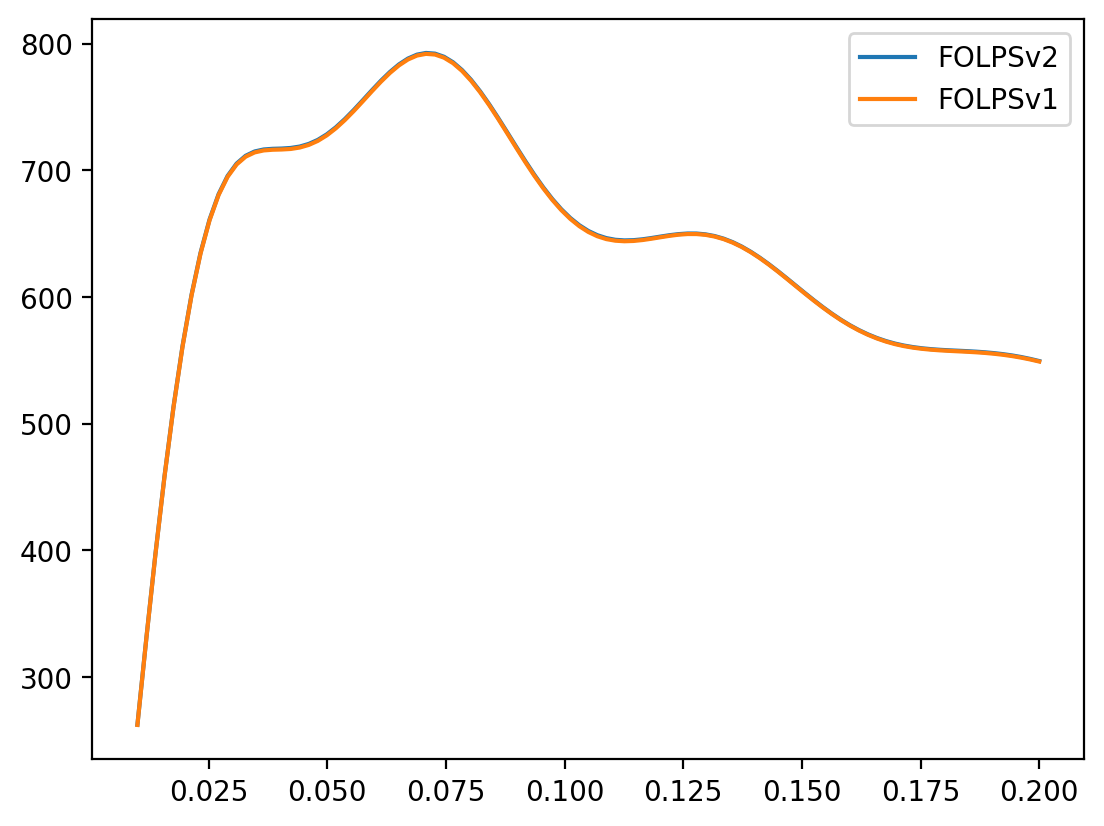

In [11]:
k=theory2.k
plt.plot(k,k*a,label='FOLPSv2')
plt.plot(k,k*d,label='FOLPSv1')
plt.legend()

In [12]:
template.init.update(with_now='peakaverage')
template()
template.calculate()
# theory.initialize()
# theory.calculate()

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [13]:
print(hasattr(template, 'pk_dd'))       # should be True
print(hasattr(template, 'pknow_dd'))    # should be True
print(template.pk_dd.shape) 

True
True
(400,)


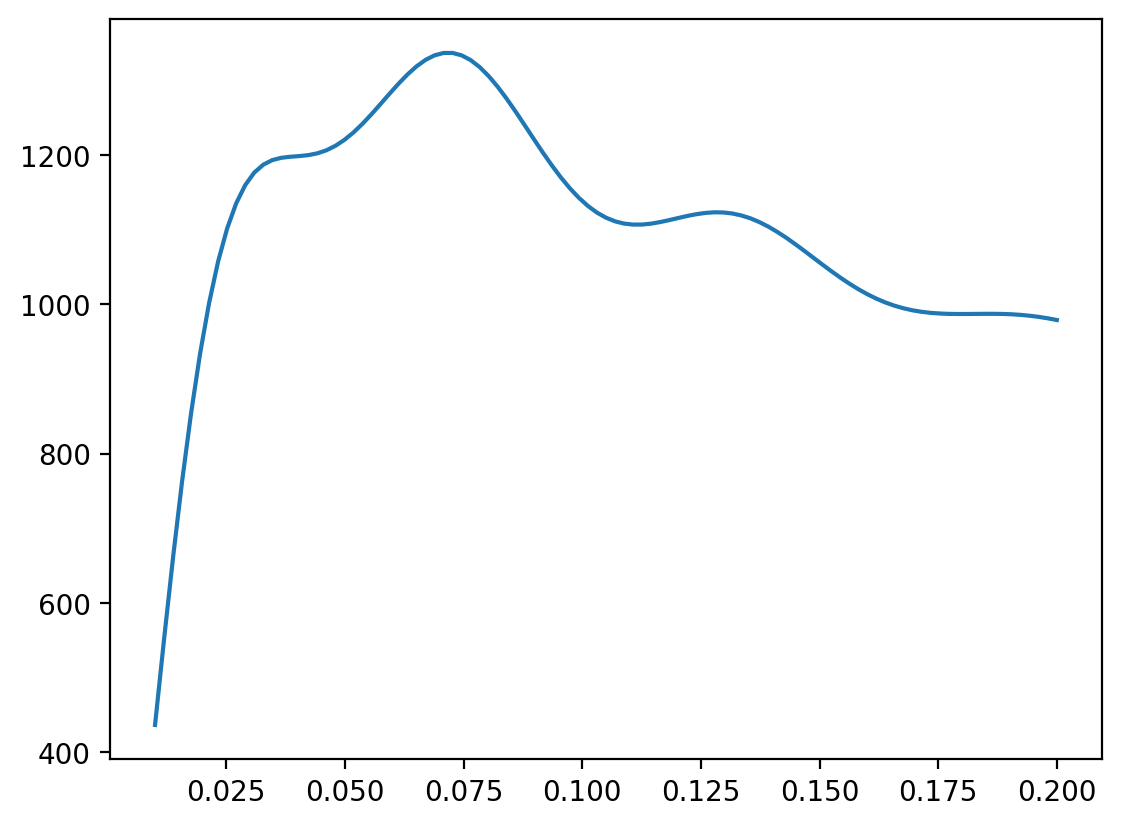

In [40]:
plt.plot(theory.k,a*theory.k)

In [4]:
# import folps
import desilike
print(desilike.__file__)

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/desilike/main/lib/python3.10/site-packages/desilike/__init__.py


In [22]:
theory2.initialize()
theory2.calculate()

Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


AttributeError: <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x7f1e2879fd30> has not attribute cosmo; try calling it first?

In [8]:
pars = [1.0, 0.5, 0.3, 0.1, 0.01, 0.02, 0.03, 0.04, 0.001, 0.002, 0.0]
theory2()

Loading matrices from matrices_nfftlog128_Afull_True_remove-DeltaP_False.npy


AttributeError: calculator FOLPSv2PowerSpectrumMultipoles has no attribute kt; have you run any calculation already by calling this calculator or calculators that depend on it (typically, a likelihood?)

In [19]:
dir(theory)

['__call__',
 '__class__',
 '__clear__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_default_options',
 '_get_non_linear',
 '_klim',
 '_mpicomm',
 '_pt_attrs',
 'all_params',
 'calculate',
 'combine_bias_terms_poles',
 'copy',
 'deepcopy',
 'ells',
 'from_state',
 'fsigma8',
 'get',
 'info',
 'init',
 'initialize',
 'install',
 'k',
 'kt',
 'load',
 'log_critical',
 'log_debug',
 'log_error',
 'log_info',
 'log_warning',
 'logger',
 'matrices',
 'mpicomm',
 'mu',
 'options',
 'params',
 'pt',
 'runtime_info',
 'save',
 'set_k_mu',
 'sigma8',
 'template',
 'to_poles',
 'varied_params',
 'wmu',
 'z']

In [25]:
p = theory.calculate

In [28]:
theory.calculate

<bound method FOLPSAXPowerSpectrumMultipoles.calculate of <__main__.FOLPSAXPowerSpectrumMultipoles object at 0x7f44242b3a30>>

In [29]:
a,b,c=theory()

TypeError: cannot unpack non-iterable NoneType object

In [2]:
import desilike

In [3]:
desilike._file_

AttributeError: module 'desilike' has no attribute '_file_'

/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/cosmodesi/desilike to /tmp/pip-req-build-hqkq_qr2
  Running command git clone --filter=blob:none --quiet https://github.com/cosmodesi/desilike /tmp/pip-req-build-hqkq_qr2
  Resolved https://github.com/cosmodesi/desilike to commit c948d980209378c1596562eb90cfa4319e53b1a5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/cosmodesi/cosmoprimo to /tmp/pip-install-39jfedb5/cosmoprimo_b57a05c0d15e4b418b8ddd222ad07a94
  Running command git clone --filter=blob:none --quiet https://github.com/cosmodesi/cosmoprimo /tmp/pip-install-39jfedb5/cos

In [3]:
!python -m pip install git+https://github.com/cosmodesi/desilike

  Cloning https://github.com/cosmodesi/desilike to /tmp/pip-req-build-m70walvh
  Running command git clone --filter=blob:none --quiet https://github.com/cosmodesi/desilike /tmp/pip-req-build-m70walvh
  Resolved https://github.com/cosmodesi/desilike to commit c948d980209378c1596562eb90cfa4319e53b1a5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/cosmodesi/cosmoprimo to /tmp/pip-install-sje7gw1i/cosmoprimo_a8ff0fa10f2f40d7ad366e7ebcc31d6c
  Running command git clone --filter=blob:none --quiet https://github.com/cosmodesi/cosmoprimo /tmp/pip-install-sje7gw1i/cosmoprimo_a8ff0fa10f2f40d7ad366e7ebcc31d6c
  Resolved https://github.com/cosmodesi/cosmoprimo to commit f35dec664b50dea83033204a8cdb6ec586be30b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━